<a href="https://colab.research.google.com/github/JimenaBaripatti/FeatureEngineering/blob/main/Fire_FSA_and_demographic_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Add New Features (FSA and Demographics) including some data exploration**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# setting up libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm 
import statistics
from sklearn.metrics import matthews_corrcoef
from scipy.stats import chi2_contingency
import math
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline


# Setting working directory
#os.chdir("/content/drive/MyDrive/Colab Notebooks/Data/")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [ ]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 359 kB/s 


# Fire data

In [ ]:
#load data sets
#df=pd.read_csv('Fire Incidents Data.csv')
#df_fsa=pd.read_csv('fire_FSA.csv')
#df_station=pd.read_csv('fire-station-locations.csv')

#load data sets from github
df=pd.read_csv('https://raw.githubusercontent.com/JimenaBaripatti/FeatureEngineering/main/data/Fire_Incidents_Data.csv')
df_fsa=pd.read_csv('https://raw.githubusercontent.com/JimenaBaripatti/FeatureEngineering/main/data/fire_FSA.csv')
df_station=pd.read_csv('https://raw.githubusercontent.com/JimenaBaripatti/FeatureEngineering/main/data/fire-station-locations_clean.csv')

In [ ]:
df.columns

Index(['_id', 'Area_of_Origin', 'Building_Status', 'Business_Impact',
       'Civilian_Casualties', 'Count_of_Persons_Rescued',
       'Estimated_Dollar_Loss', 'Estimated_Number_Of_Persons_Displaced',
       'Exposures', 'Ext_agent_app_or_defer_time', 'Extent_Of_Fire',
       'Final_Incident_Type', 'Fire_Alarm_System_Impact_on_Evacuation',
       'Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence',
       'Fire_Under_Control_Time', 'Ignition_Source', 'Incident_Number',
       'Incident_Station_Area', 'Incident_Ward', 'Initial_CAD_Event_Type',
       'Intersection', 'Last_TFS_Unit_Clear_Time', 'Latitude',
       'Level_Of_Origin', 'Longitude', 'Material_First_Ignited',
       'Method_Of_Fire_Control', 'Number_of_responding_apparatus',
       'Number_of_responding_personnel', 'Possible_Cause', 'Property_Use',
       'Smoke_Alarm_at_Fire_Origin',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
       'Smoke_Alarm_Impact_on_Persons

In [ ]:
(df.isna().mean().round(4)*100).sort_values(ascending=False)

Exposures                                                        98.10
Smoke_Alarm_at_Fire_Origin_Alarm_Failure                         36.05
Smoke_Alarm_at_Fire_Origin_Alarm_Type                            36.05
Extent_Of_Fire                                                   36.05
Business_Impact                                                  36.05
Fire_Alarm_System_Presence                                       36.05
Smoke_Alarm_at_Fire_Origin                                       36.05
Level_Of_Origin                                                  36.05
Estimated_Number_Of_Persons_Displaced                            36.05
Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation    36.05
Smoke_Spread                                                     36.05
Sprinkler_System_Operation                                       36.05
Sprinkler_System_Presence                                        36.05
Fire_Alarm_System_Operation                                      36.05
Fire_A

In [ ]:
cat_var = df.loc[:,df.dtypes == np.object].columns

In [ ]:
DT_var=["TFS_Alarm_Time", "TFS_Arrival_Time", "Ext_agent_app_or_defer_time","Fire_Under_Control_Time", "Last_TFS_Unit_Clear_Time"]
df=df[DT_var]
n_missing=[df[x].isnull().sum() for x in DT_var]
pd.DataFrame(data=n_missing,index=DT_var, columns=['missing records']).sort_values(by=['missing records'], ascending=False)

,missing records
Ext_agent_app_or_defer_time,1914
Fire_Under_Control_Time,1902
TFS_Alarm_Time,0
TFS_Arrival_Time,0
Last_TFS_Unit_Clear_Time,0


In [ ]:
n_cat = [df[x].unique().shape[0] for x in cat_var]
n_missing=[df[x].isnull().sum() for x in cat_var]
pd.DataFrame(data=zip(n_cat,n_missing),index=cat_var, columns=['number of categories','number of missing records']).sort_values(by=['number of categories'], ascending=False)

,number of categories,number of missing records
TFS_Arrival_Time,17536,0
TFS_Alarm_Time,17536,0
Incident_Number,17536,0
Last_TFS_Unit_Clear_Time,17534,0
Fire_Under_Control_Time,15624,1902
Ext_agent_app_or_defer_time,15615,1914
Intersection,7759,1
Property_Use,284,1
Initial_CAD_Event_Type,115,0
Ignition_Source,85,1913


##Add new feature: FSA based on Latitude and Longitude

In [ ]:
#Extract postal code from latitude and longitude information 
#Reverse Geocoding

from geopy.geocoders import Nominatim #from open street maps and its free
from geopy.geocoders import GoogleV3
from geopy.geocoders import Bing

# create the locator
geolocator = Nominatim(user_agent="jsqzhu@gmail.com") # user_agent="specify_your_app_name_here" 
# you may need to use your own email if the next step gives you HTTP Error 403


### fire station number and FSA

In [ ]:
df_station.columns

Index(['_id', 'ID', 'NAME', 'ADDRESS', 'ADDRESS_POINT_ID', 'ADDRESS_ID',
       'CENTRELINE_ID', 'MAINT_STAGE', 'ADDRESS_NUMBER', 'LINEAR_NAME_FULL',
       'POSTAL_CODE', 'GENERAL_USE', 'CLASS_FAMILY_DESC', 'ADDRESS_ID_LINK',
       'PLACE_NAME', 'X', 'Y', 'LATITUDE', 'LONGITUDE', 'WARD_NAME',
       'MUNICIPALITY_NAME', 'OBJECTID', 'geometry'],
      dtype='object')

In [ ]:
df_station['NAME'][0][-3:]

'211'

In [ ]:
df_station['Incident_Station_Area']=df_station['NAME'].apply(lambda x: x[-3:])

In [ ]:
df_station['Incident_Station_Area'].unique()

array(['211', '342', '343', '332', '214', '426', '422', '232', '121',
       '412', '134', '314', '331', '115', '132', '433', '441', '341',
       '434', '311', '323', '234', '435', '424', '221', '224', '244',
       '226', '123', '131', '223', '231', '312', '243', '444', '215',
       '423', '212', '227', '222', '322', '213', '321', '445', '413',
       '116', '432', '225', '431', '415', '113', '133', '425', '233',
       '421', '125', '142', '344', '315', '326', '325', '443', '146',
       '122', '143', '245', '333', '241', '145', '235', '442', '411',
       '112', '111', '114', '242', '346', '334', '324', '141', '313',
       '335', '345', '135'], dtype=object)

In [ ]:
df_station['Longitude']=df_station['geometry'].str[37:51]
df_station['Latitude'] = df_station['geometry'].str[53:-2]

In [ ]:
df_station['Longitude']

0     -79.2428700354
1     -79.4486262605
2     -79.4307521573
3     -79.3895641903
4     -79.1636016042
5     -79.4388667128
6     -79.4909411711
7     -79.2668510713
8     -79.4067807495
9     -79.6176378075
10    -79.3997683019
11    -79.3846617685
12    -79.4097737524
13    -79.3406860701
14    -79.4285718669
15    -79.5029381693
16    -79.5719196489
17    -79.4411405906
18    -79.5439889406
19    -79.3939758413
20    -79.3346621153
21    -79.1915220291
22    -79.5069699934
23    -79.4796294010
24    -79.2550627035
25    -79.3165970102
26    -79.2991153162
27    -79.2990652659
28    -79.3467260333
29    -79.4021572824
30    -79.2332610777
31    -79.2277876628
32    -79.3889203796
33    -79.2629602053
34    -79.5826959880
35    -79.1480658922
36    -79.4647539608
37    -79.1886200061
38    -79.3050381995
39    -79.2840906320
40    -79.3423437199
41    -79.2259619086
42    -79.3648513993
43    -79.5451030832
44    -79.5869058523
45    -79.3650636555
46    -79.5493536952
47    -79.268

In [ ]:
df_station['Latitude']

0     43.8239927252
1     43.6793661319
2     43.6801051518
3     43.6483065340
4     43.7942107669
5     43.6450864408
6     43.6644021871
7     43.7549669456
8     43.7485400772
9     43.7381082894
10    43.7096567595
11    43.6630574202
12    43.6473361194
13    43.7744035512
14    43.7197981433
15    43.6280185381
16    43.6949604664
17    43.6945203033
18    43.6025703359
19    43.6859508064
20    43.6795428878
21    43.7610681663
22    43.6011185171
23    43.6583545553
24    43.7347901433
25    43.6951874596
26    43.7816824953
27    43.6819233410
28    43.7458140064
29    43.7262170050
30    43.7239567618
31    43.7646440089
32    43.6718748613
33    43.7891369171
34    43.6574667399
35    43.7773919351
36    43.6647417826
37    43.8049322416
38    43.6691630089
39    43.7203994274
40    43.6909861622
41    43.7954066089
42    43.7087098624
43    43.6493481781
44    43.7402187056
45    43.7691459436
46    43.6233410115
47    43.6959168732
48    43.6464360660
49    43.7178772081


In [ ]:
# getting the postal code and extract FSA from firestation location
df_station['location'] = df_station.apply(lambda x: geolocator.reverse(str(x['Latitude'])+", "+str(x['Longitude'])).address.split(",")[-2], axis=1)

In [ ]:
df_station['Station_FSA']=df_station['location'].apply(lambda x: (re.findall("M[0-9][A-Z]",x))[0])

### clean up fire incident file with FSA - impute incorrect FSA with fire station FSA


In [ ]:
# same method applied to fire_incident dataset to obtain the postal code and extract FSA as a new feature
# due to processing time, this step is being carried out locally and re-imported 
#df['location'] = df.apply(lambda x: geolocator.reverse(str(x['Latitude'])+", "+str(x['Longitude'])).address.split(",")[-2], axis=1)
#df['FSA']=df['location'].apply(lambda x: x[0:4])
df[df_fsa['FSA'].isnull()]

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Number,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Latitude,Level_Of_Origin,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties
17500,1964429,81 - Engine Area,NaN,NaN,0,0,3000.0,NaN,NaN,2011-09-26T23:03:00,NaN,01 - Fire,NaN,NaN,NaN,2011-09-26T23:07:00,81 - Vehicle - Electrical,F11126605,214,NaN,VEFH,NaN,2011-09-26T23:35:00,NaN,NaN,NaN,99 - Undetermined (formerly 98),1 - Extinguished by fire department,3,10,51 - Mechanical Failure,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3 - Fire with smoke showing only - including vehicle, outdoor fires",2011-09-26T22:55:12,2011-09-26T23:01:00,0


In [ ]:
df_fsa['FSA'].isna().sum()

1

In [ ]:
df_fsa['FSA']=df_fsa['FSA'].apply(lambda x: str(x).strip())

In [ ]:
df_fsa['FSA'].unique()

array(['M9W', 'M2N', 'M1J', 'M6M', 'M6A', 'M1E', 'M4B', 'M5H', 'M6R',
       'M1N', 'M5A', 'M4C', 'M6C', 'M1T', 'M1K', 'M2K', 'M6B', 'M6E',
       'M3J', 'M3B', 'M8Y', 'M5V', 'M9V', 'M4Y', 'M5E', 'M4T', 'M5B',
       'M3K', 'M3H', 'M6H', 'M9P', 'M6J', 'M4W', 'M6S', 'M2J', 'M1M',
       'M9G', 'M4P', 'M1C', 'M8W', 'M6P', 'M3A', 'L4J', 'M4M', 'M1B',
       'M9R', 'M5G', 'M5N', 'M5P', 'M3C', 'M5T', 'M3M', 'M4J', 'M5S',
       'M1W', 'M3L', 'M8X', 'M4X', 'M9N', 'M4S', 'M1L', 'M1P', 'M2P',
       'M4L', 'L4X', 'M5M', 'M5J', 'M3N', 'M9B', 'M1S', 'M6N', 'M9L',
       'M6K', 'M9C', 'M8Z', 'M5R', 'L4V', 'M4G', 'M8V', 'M2M', 'M9A',
       'M1G', 'M2R', 'L3R', 'M1R', 'M6L', 'M4A', 'M5C', 'M9M', 'L6B',
       'M2Z', 'M4N', 'M4V', 'M4H', 'M1H', 'M6G', 'M1V', 'M4K', 'M2H',
       'M2L', 'M1X', 'M5X', 'L4K', 'M4E', 'L4T', 'M4R', 'L4W', 'Ont',
       'K4A', 'L4L', 'L1V', 'L3T', 'ON', 'M2S', 'MRJ', 'M5K', 'M7A',
       'MK4', 'nan'], dtype=object)

In [ ]:
FSA_index_to_impute=df_fsa[df_fsa['FSA'].isin(['Ont','ON','MRJ','nan','M9G', 'L4J', 'L4X', 'L4V', 'L3R', 'L6B', 'M2Z', 'M5X', 'L4K','L4T', 'L4W', 'K4A', 'L4L', 'L1V', 'L3T', 'M2S', 'M5K', 'M7A','MK4'])].index

In [ ]:
df_fsa['fsa_imputed']=0

In [ ]:
df_fsa.at[FSA_index_to_impute, 'fsa_imputed']=1

In [ ]:
df_fsa['fsa_imputed'].value_counts()

0    17235
1    301  
Name: fsa_imputed, dtype: int64

In [ ]:
df_station.head(2)

,_id,ID,NAME,ADDRESS,ADDRESS_POINT_ID,ADDRESS_ID,CENTRELINE_ID,MAINT_STAGE,ADDRESS_NUMBER,LINEAR_NAME_FULL,POSTAL_CODE,GENERAL_USE,CLASS_FAMILY_DESC,ADDRESS_ID_LINK,PLACE_NAME,X,Y,LATITUDE,LONGITUDE,WARD_NAME,MUNICIPALITY_NAME,OBJECTID,geometry,Incident_Station_Area,Longitude,Latitude,location,FSA
0,1,21,FIRE STATION 211,900 TAPSCOTT RD,4236992,363382,4236991,REGULAR,900,Tapscott Rd,NaN,Fire/Ambulance Stations,"Land, Structure, Structure Entrance",NaN,"Fire Station 211, Ambulance Station 27",NaN,NaN,NaN,NaN,Scarborough North (23),Scarborough,1520443,"{u'type': u'Point', u'coordinates': (-79.2428700354, 43.8239927252)}",211,-79.2428700354,43.8239927252,M1X 1C3,M1X
1,2,60,FIRE STATION 342,106 ASCOT AVE,764237,70190,1140634,REGULAR,106,Ascot Ave,NaN,Fire Station,"Land, Structure, Structure Entrance",NaN,Fire Station 342,NaN,NaN,NaN,NaN,Davenport (9),former Toronto,1541526,"{u'type': u'Point', u'coordinates': (-79.4486262605, 43.6793661319)}",342,-79.4486262605,43.6793661319,M6E 1J8,M6E


In [ ]:
df_station['Incident_Station_Area'].unique()

array(['211', '342', '343', '332', '214', '426', '422', '232', '121',
       '412', '134', '314', '331', '115', '132', '433', '441', '341',
       '434', '311', '323', '234', '435', '424', '221', '224', '244',
       '226', '123', '131', '223', '231', '312', '243', '444', '215',
       '423', '212', '227', '222', '322', '213', '321', '445', '413',
       '116', '432', '225', '431', '415', '113', '133', '425', '233',
       '421', '125', '142', '344', '315', '326', '325', '443', '146',
       '122', '143', '245', '333', '241', '145', '235', '442', '411',
       '112', '111', '114', '242', '346', '334', '324', '141', '313',
       '335', '345', '135'], dtype=object)

In [ ]:
df_fsa['Incident_Station_Area']=df_fsa['Incident_Station_Area'].astype(str)

In [ ]:
df_fsa['Incident_Station_Area'].unique()

array(['441', '116', '221', '133', '132', '215', '235', '231', '332',
       '426', '225', '325', '226', '341', '421', '244', '141', '115',
       '415', '431', '331', '413', '314', '333', '311', '145', '143',
       '342', '443', '312', '223', '134', '214', '434', '423', '233',
       '114', '112', '224', '326', '212', '343', '135', '125', '315',
       '234', '324', '113', '142', '146', '313', '442', '222', '241',
       '345', '232', '121', '432', '425', '334', '411', '445', '243',
       '323', '435', '213', '422', '412', '123', '344', '111', '242',
       '321', '433', '245', '211', '131', '322', '444', '122', '335',
       '227', '346', '424'], dtype=object)

In [ ]:
df_station[['Incident_Station_Area','Station_FSA']].dtypes

Incident_Station_Area    object
Station_FSA              object
dtype: object

In [ ]:
df_fsa[['Incident_Station_Area']].dtypes

Incident_Station_Area    object
dtype: object

In [ ]:
df_fsa_copy=pd.merge(df_fsa,df_station[['Incident_Station_Area','Station_FSA']],how='left', on='Incident_Station_Area')

In [ ]:
df_fsa_copy.head(2)

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Number,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Latitude,Level_Of_Origin,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties,location,FSA,fsa_imputed,Station_FSA
0,1964465,81 - Engine Area,NaN,NaN,0,0,15000.0,NaN,NaN,2018-02-25T02:12:00,NaN,01 - Fire,NaN,NaN,NaN,2018-02-25T02:15:40,999 - Undetermined,F18020956,441,1.0,Vehicle Fire,Dixon Rd / 427 N Dixon Ramp,2018-02-25T02:38:31,43.686558,NaN,-79.599419,47 - Vehicle,1 - Extinguished by fire department,1,4,99 - Undetermined,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, spreading outdoor fire)",2018-02-25T02:04:29,2018-02-25T02:10:11,0,M9W 5N4,M9W,0,M9W
1,1964466,"75 - Trash, rubbish area (outside)",NaN,NaN,0,0,50.0,NaN,NaN,2018-02-25T02:29:42,NaN,01 - Fire,NaN,NaN,NaN,2018-02-25T02:32:24,999 - Undetermined,F18020969,116,18.0,Fire - Grass/Rubbish,Sheppard Ave E / Clairtrell Rd,2018-02-25T02:35:58,43.766135,NaN,-79.390039,97 - Other,1 - Extinguished by fire department,1,4,03 - Suspected Vandalism,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-25T02:24:43,2018-02-25T02:29:31,0,M2N 3B1,M2N,0,M5H


In [ ]:
df_fsa_copy['FSA'][df_fsa_copy['fsa_imputed']==1]=df_fsa_copy['Station_FSA']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_fsa_copy.drop(['Station_FSA'],axis=1, inplace=True)

In [ ]:
df_fsa_copy.head(2)

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Number,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Latitude,Level_Of_Origin,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties,location,FSA,fsa_imputed
0,1964465,81 - Engine Area,NaN,NaN,0,0,15000.0,NaN,NaN,2018-02-25T02:12:00,NaN,01 - Fire,NaN,NaN,NaN,2018-02-25T02:15:40,999 - Undetermined,F18020956,441,1.0,Vehicle Fire,Dixon Rd / 427 N Dixon Ramp,2018-02-25T02:38:31,43.686558,NaN,-79.599419,47 - Vehicle,1 - Extinguished by fire department,1,4,99 - Undetermined,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, spreading outdoor fire)",2018-02-25T02:04:29,2018-02-25T02:10:11,0,M9W 5N4,M9W,0
1,1964466,"75 - Trash, rubbish area (outside)",NaN,NaN,0,0,50.0,NaN,NaN,2018-02-25T02:29:42,NaN,01 - Fire,NaN,NaN,NaN,2018-02-25T02:32:24,999 - Undetermined,F18020969,116,18.0,Fire - Grass/Rubbish,Sheppard Ave E / Clairtrell Rd,2018-02-25T02:35:58,43.766135,NaN,-79.390039,97 - Other,1 - Extinguished by fire department,1,4,03 - Suspected Vandalism,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-25T02:24:43,2018-02-25T02:29:31,0,M2N 3B1,M2N,0


In [ ]:
df_fsa=df_fsa_copy

##Explore data

In [ ]:
df['Area_of_Origin'].value_counts()

24 - Cooking Area or Kitchen                                                 2878
81 - Engine Area                                                             1931
44 - Trash, Rubbish Storage (inc garbage chute room, garbage/industri        1070
64 - Porch or Balcony                                                        957 
22 - Sleeping Area or Bedroom (inc. patients room, dormitory, etc)           871 
21 - Living Area (e.g. living, TV, recreation, etc)                          596 
75 - Trash, rubbish area (outside)                                           429 
97 - Other - unclassified                                                    418 
99 - Undetermined  (formerly 98)                                             402 
42 - Garage                                                                  401 
83 - Electrical Systems                                                      396 
27 - Laundry Area                                                            366 
25 - Washroom or

In [ ]:
df['Final_Incident_Type'].value_counts()

01 - Fire                                                                                  15516
03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vandal,child playing,recycling or dump fires)    1914 
02 - Explosion (including during Fire, excluding Codes 3 & 11-13)                          106  
Name: Final_Incident_Type, dtype: int64

In [ ]:
df['Initial_CAD_Event_Type'].value_counts()

FIR                                       3929
Fire - Grass/Rubbish                      1698
VEF                                       1652
FIHR                                      1617
FICI                                      1303
FIG                                       917 
Fire - Residential                        898 
FAHR                                      787 
VEFH                                      548 
Vehicle Fire                              478 
Fire -  Highrise Residential              379 
Fire - Commercial/Industrial              375 
FACI                                      303 
Alarm Highrise Residential                235 
FIHRD                                     199 
FAR                                       175 
Vehicle Fire - Highway                    157 
FAHRD                                     154 
FITP                                      113 
FIS                                       107 
CC                                        82  
Alarm Commerc

In [ ]:
df['Property_Use'].value_counts(normalize=True)

323 - Multi-Unit Dwelling - Over 12 Units                                        0.220644
301 - Detached Dwelling                                                          0.141774
901 - Automobile                                                                 0.082350
896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)    0.053721
302 - Semi-Detached Dwelling                                                     0.044140
848 - Trash/Rubbish/Garbage Container or Dumpster                                0.042315
303 - Attached Dwelling (eg. rowhouse, townhouse, etc.)                          0.034502
861 - Open Land (eg. light ground cover, bush, grass, etc.)                      0.027032
902 - Small Truck (eg. pick-up, van, etc.)                                       0.020816
321 - Multi-Unit Dwelling - 2 to 6 Units                                         0.016424
331 - Apartment, Flat, Tenement with Business                                    0.016196
151 - Rest

In [ ]:
df['Property_Use'].isnull().sum()

1

# Demographic data

In [4]:
#load household/dwelling structure/construction age by FSA
df_household=pd.read_csv('https://raw.githubusercontent.com/JimenaBaripatti/FeatureEngineering/main/data/2016_CensusDataFSA_HouseholdStructure.csv') #possible features: ratio of highrises vs other, age of structure??
#load poulation data by FSA
df_population=pd.read_csv('https://raw.githubusercontent.com/JimenaBaripatti/FeatureEngineering/main/data/2016_CensusDataFSA_Population.csv') #population density? need to find area
#load family structure by FSA (might be redundant) 
#df_family=pd.read_csv('2016_CensusDataFSA_FamilyStructure.csv')

In [5]:
#load geographic data
fsa=pd.read_csv('https://raw.githubusercontent.com/JimenaBaripatti/FeatureEngineering/main/data/fsa_area_2016.csv')
#set first row as column names
fsa.columns=fsa.iloc[0]
fsa=fsa[1:]

In [6]:
fsa=fsa.rename(columns={"CFSAUID":"Geo Code"})

##Population density per FSA

In [7]:
df_population['Category'].unique()

array(['Population; 2016', 'Population; 2011',
       'Population percentage change; 2011 to 2016',
       'Total private dwellings',
       'Private dwellings occupied by usual residents',
       'Population density per square kilometre',
       'Land area in square kilometres'], dtype=object)

In [8]:
population_by_FSA=df_population[df_population['Category']=='Population; 2016']

In [9]:
# join population and area data together
population_density_by_FSA=pd.merge(population_by_FSA[['Geo Code','Counts']], fsa, on='Geo Code', how='inner')
#calculate density
population_density_by_FSA['Counts']=pd.to_numeric(population_density_by_FSA['Counts'])
population_density_by_FSA['Area Sq Km']=pd.to_numeric(population_density_by_FSA['Area Sq Km'])
population_density_by_FSA['density']=round(population_density_by_FSA['Counts']/population_density_by_FSA['Area Sq Km'],2)
#population_density_by_FSA.dtypes

In [10]:
population_density_by_FSA.head()

,Geo Code,Counts,PRUID,PRNAME,Area Sq Km,density
0,M1B,66108,35,Ontario,37.470902,1764.25
1,M1C,35626,35,Ontario,14.761468,2413.45
2,M1E,46943,35,Ontario,16.339701,2872.94
3,M1G,29690,35,Ontario,9.496478,3126.42
4,M1H,24383,35,Ontario,5.121544,4760.87


In [11]:
population_density_by_FSA=population_density_by_FSA.drop(columns=[col for col in population_density_by_FSA.columns if col not in ['Geo Code','density']], axis=1)

In [12]:
population_density_by_FSA.head()

,Geo Code,density
0,M1B,1764.25
1,M1C,2413.45
2,M1E,2872.94
3,M1G,3126.42
4,M1H,4760.87


##building condition

In [13]:
df_household['Category'].unique()

array(['Total - Private households by household type - 100% data',
       'Total - Private households by tenure - 25% sample data',
       'Total - Occupied private dwellings by condominium status - 25% sample data',
       'Total - Occupied private dwellings by number of bedrooms - 25% sample data',
       'Total - Occupied private dwellings by number of rooms - 25% sample data',
       'Average number of rooms per dwelling',
       'Total - Private households by number of persons per room - 25% sample data',
       'Total - Private households by housing suitability - 25% sample data',
       'Total - Occupied private dwellings by period of construction - 25% sample data',
       'Total - Occupied private dwellings by dwelling condition - 25% sample data',
       'Total - Private households by number of household maintainers - 25% sample data',
       'Total - Private households by age of primary household maintainers - 25% sample data',
       'Total -  Owner and tenant households wi

In [14]:
#residential building condition
df_condition=df_household.loc[df_household['Category']=='Total - Occupied private dwellings by dwelling condition - 25% sample data']
df_condition=df_condition.pivot(index='Geo Code', columns='Sub Category', values='Counts')

In [15]:
#clean up data frame
df_condition=df_condition.rename(columns={df_condition.columns[0]: 'Total'})
df_condition=df_condition[df_condition['Total']!='x']
df_condition['Major repairs needed']=pd.to_numeric(df_condition['Major repairs needed'])
df_condition['Total']=pd.to_numeric(df_condition['Total'])
#proportion of residents that require major repairs
df_condition['poor_building_condition']=(df_condition['Major repairs needed'])/(df_condition['Total'])

In [16]:
df_condition=df_condition.reset_index()
df_condition.head()

Sub Category,Geo Code,Total,Major repairs needed,Only regular maintenance or minor repairs needed,poor_building_condition
0,Canada,14072075,920480,13151600,0.065412
1,M1B,20235,1130,19105,0.055844
2,M1C,11270,465,10805,0.041260
3,M1E,17155,1600,15555,0.093267
4,M1G,9825,1075,8750,0.109415


In [17]:
df_condition=df_condition.drop(columns=[col for col in df_condition.columns if col not in ['Geo Code','poor_building_condition']], axis=1)

## dwell type: % condo

In [18]:
#dwelling type (condo vs non-condo)
df_dwell=df_household.loc[df_household['Category']=='Total - Occupied private dwellings by condominium status - 25% sample data']
df_dwell=df_dwell.pivot(index='Geo Code', columns='Sub Category', values='Counts')

In [19]:
df_dwell.columns

Index([nan, 'Condominium', 'Not condominium'], dtype='object', name='Sub Category')

In [20]:
#clean up data frame
df_dwell=df_dwell.rename(columns={df_dwell.columns[0]: 'Total'})
df_dwell=df_dwell[df_dwell['Total']!='x']
df_dwell['Condominium']=pd.to_numeric(df_dwell['Condominium'])
df_dwell['Total']=pd.to_numeric(df_dwell['Total'])
#proportion of residents that live in condo
df_dwell['condo_dwelling']=(df_dwell['Condominium'])/(df_dwell['Total'])

In [21]:
df_dwell=df_dwell.reset_index()
df_dwell.head()

Sub Category,Geo Code,Total,Condominium,Not condominium,condo_dwelling
0,Canada,14072080,1874835,12197240,0.133231
1,M1B,20235,5570,14660,0.275266
2,M1C,11270,300,10970,0.026619
3,M1E,17155,3690,13470,0.215098
4,M1G,9825,295,9535,0.030025


In [22]:
df_dwell=df_dwell.drop(columns=['Total','Condominium','Not condominium'], axis=1)

## Age and Gender

In [23]:
TO_census=pd.read_csv('https://raw.githubusercontent.com/JimenaBaripatti/FeatureEngineering/main/data/ToCensus.csv')

In [41]:
Age_by_FSA=TO_census[['GEO_CODE (POR)', 'DIM: Profile of Forward Sortation Areas (2247)','Dim: Sex (3): Member ID: [1]: Total - Sex']].loc[(TO_census['DIM: Profile of Forward Sortation Areas (2247)']=='Average age of the population') | (TO_census['DIM: Profile of Forward Sortation Areas (2247)']=='Median age of the population')]

In [43]:
Age_by_FSA=Age_by_FSA.pivot(index='GEO_CODE (POR)', columns='DIM: Profile of Forward Sortation Areas (2247)',values='Dim: Sex (3): Member ID: [1]: Total - Sex')

In [47]:
#remove rows with missing 'age' values
Age_by_FSA=Age_by_FSA[Age_by_FSA['Average age of the population']!='x']

In [51]:
Age_by_FSA['Average age of the population']=pd.to_numeric(Age_by_FSA['Average age of the population'])
Age_by_FSA['Median age of the population']=pd.to_numeric(Age_by_FSA['Median age of the population'])
Age_by_FSA.dtypes

DIM: Profile of Forward Sortation Areas (2247)
Average age of the population    float64
Median age of the population     float64
dtype: object

In [54]:
Gender_by_FSA=TO_census[['GEO_CODE (POR)','Dim: Sex (3): Member ID: [1]: Total - Sex','Dim: Sex (3): Member ID: [2]: Male']].loc[(TO_census['DIM: Profile of Forward Sortation Areas (2247)']=='Total - Age groups and average age of the population - 100% data')]

In [55]:
Gender_by_FSA.head()

,GEO_CODE (POR),Dim: Sex (3): Member ID: [1]: Total - Sex,Dim: Sex (3): Member ID: [2]: Male
7,M1B,66110,31625
2254,M1C,35625,17465
4501,M1E,46940,22345
6748,M1G,29690,14470
8995,M1H,24385,11785


In [57]:
#remove rows with missing 'age' values
Gender_by_FSA=Gender_by_FSA[Gender_by_FSA['Dim: Sex (3): Member ID: [1]: Total - Sex']!='x']

In [58]:
Gender_by_FSA['Dim: Sex (3): Member ID: [1]: Total - Sex']=pd.to_numeric(Gender_by_FSA['Dim: Sex (3): Member ID: [1]: Total - Sex'])
Gender_by_FSA['Dim: Sex (3): Member ID: [2]: Male']=pd.to_numeric(Gender_by_FSA['Dim: Sex (3): Member ID: [2]: Male'])
Gender_by_FSA.dtypes

GEO_CODE (POR)                               object
Dim: Sex (3): Member ID: [1]: Total - Sex    int64 
Dim: Sex (3): Member ID: [2]: Male           int64 
dtype: object

In [59]:
Gender_by_FSA['male']=Gender_by_FSA['Dim: Sex (3): Member ID: [2]: Male']/Gender_by_FSA['Dim: Sex (3): Member ID: [1]: Total - Sex']

In [ ]:
Gender_by

In [60]:
Gender_by_FSA.dtypes

GEO_CODE (POR)                               object 
Dim: Sex (3): Member ID: [1]: Total - Sex    int64  
Dim: Sex (3): Member ID: [2]: Male           int64  
male                                         float64
dtype: object

In [66]:
Age_by_FSA.columns=['Average_Age','Median_Age']

In [ ]:
Gender_by_FSA.set_index('GEO_CODE (POR)')

In [73]:
Gender_by_FSA.columns

Index(['GEO_CODE (POR)', 'Dim: Sex (3): Member ID: [1]: Total - Sex',
       'Dim: Sex (3): Member ID: [2]: Male', 'male'],
      dtype='object')

In [81]:
other_census=Gender_by_FSA.set_index('GEO_CODE (POR)').join(Age_by_FSA, how='left')

In [82]:
other_census.drop(['Dim: Sex (3): Member ID: [1]: Total - Sex','Dim: Sex (3): Member ID: [2]: Male'],axis=1, inplace=True)

In [90]:
other_census.reset_index(inplace=True)

In [94]:
other_census.columns

Index(['GEO_CODE (POR)', 'male', 'Average_Age', 'Median_Age'], dtype='object')

In [95]:
other_census=other_census.rename(columns={'GEO_CODE (POR)':'FSA'})

In [84]:
#Merge Demographic data
from functools import reduce
data_frames=[population_density_by_FSA,df_condition, df_dwell]
df_merge=reduce(lambda left, right: pd.merge(left, right, on=['Geo Code'], how='outer'),data_frames)

In [85]:
df_merge=df_merge.rename(columns={'Geo Code': 'FSA'})

In [ ]:
df_merge

In [96]:
data_frames=[df_merge, other_census]
df_demographics=reduce(lambda left, right: pd.merge(left, right, on=['FSA'], how='outer'), data_frames)

In [ ]:
df_demographics.to_csv('demographics.csv')

In [ ]:
df_demographics

,FSA,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male
0,M1B,1764.25,0.055844,0.275266,38.9,38.2,0.478369
1,M1C,2413.45,0.041260,0.026619,42.1,44.0,0.490246
2,M1G,3126.42,0.109415,0.030025,38.6,37.2,0.487369
3,M1H,4760.87,0.055991,0.370661,39.9,38.1,0.483289
4,M1J,5700.21,0.114064,0.191333,38.1,37.2,0.476158
5,M1K,5309.84,0.093393,0.143853,39.9,40.1,0.481367
6,M1L,4020.48,0.083400,0.097541,38.3,38.0,0.485108
7,M1M,2412.93,0.078341,0.120968,42.6,44.8,0.482759
8,M1N,3552.06,0.089011,0.044505,43.0,45.2,0.481256
9,M1P,3849.76,0.057704,0.429133,40.5,39.3,0.472021


# Combine Fire+Demographic data

In [ ]:
#load demographics data
df_demographics=pd.read_csv('demographics.csv')
df_demographics=df_demographics.iloc[:,1: ]

In [ ]:
Fire_w_demographics=pd.merge(df_fsa, df_demographics,on='FSA',how='left')
Fire_w_demographics.head(2)

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Number,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Latitude,Level_Of_Origin,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties,location,FSA,fsa_imputed,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male
0,1964465,81 - Engine Area,NaN,NaN,0,0,15000.0,NaN,NaN,2018-02-25T02:12:00,NaN,01 - Fire,NaN,NaN,NaN,2018-02-25T02:15:40,999 - Undetermined,F18020956,441,1.0,Vehicle Fire,Dixon Rd / 427 N Dixon Ramp,2018-02-25T02:38:31,43.686558,NaN,-79.599419,47 - Vehicle,1 - Extinguished by fire department,1,4,99 - Undetermined,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, spreading outdoor fire)",2018-02-25T02:04:29,2018-02-25T02:10:11,0,M9W 5N4,M9W,0,1411.27,0.066034,0.175848,39.6,38.3,0.490844
1,1964466,"75 - Trash, rubbish area (outside)",NaN,NaN,0,0,50.0,NaN,NaN,2018-02-25T02:29:42,NaN,01 - Fire,NaN,NaN,NaN,2018-02-25T02:32:24,999 - Undetermined,F18020969,116,18.0,Fire - Grass/Rubbish,Sheppard Ave E / Clairtrell Rd,2018-02-25T02:35:58,43.766135,NaN,-79.390039,97 - Other,1 - Extinguished by fire department,1,4,03 - Suspected Vandalism,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-25T02:24:43,2018-02-25T02:29:31,0,M2N 3B1,M2N,0,7581.15,0.036021,0.682775,39.9,37.0,0.469236


In [ ]:
Fire_w_demographics[Fire_w_demographics['fsa_imputed']==0]['FSA'].unique()

array(['M9W', 'M2N', 'M1J', 'M6M', 'M6A', 'M1E', 'M4B', 'M5H', 'M6R',
       'M1N', 'M5A', 'M4C', 'M6C', 'M1T', 'M1K', 'M2K', 'M6B', 'M6E',
       'M3J', 'M3B', 'M8Y', 'M5V', 'M9V', 'M4Y', 'M5E', 'M4T', 'M5B',
       'M3K', 'M3H', 'M6H', 'M9P', 'M6J', 'M4W', 'M6S', 'M2J', 'M1M',
       'M9G', 'M4P', 'M1C', 'M8W', 'M6P', 'M3A', 'L4J', 'M4M', 'M1B',
       'M9R', 'M5G', 'M5N', 'M5P', 'M3C', 'M5T', 'M3M', 'M4J', 'M5S',
       'M1W', 'M3L', 'M8X', 'M4X', 'M9N', 'M4S', 'M1L', 'M1P', 'M2P',
       'M4L', 'L4X', 'M5M', 'M5J', 'M3N', 'M9B', 'M1S', 'M6N', 'M9L',
       'M6K', 'M9C', 'M8Z', 'M5R', 'L4V', 'M4G', 'M8V', 'M2M', 'M9A',
       'M1G', 'M2R', 'L3R', 'M1R', 'M6L', 'M4A', 'M5C', 'M9M', 'L6B',
       'M2Z', 'M4N', 'M4V', 'M4H', 'M1H', 'M6G', 'M1V', 'M4K', 'M2H',
       'M2L', 'M1X', 'M5X', 'L4K', 'M4E', 'L4T', 'M4R', 'L4W', 'K4A',
       'L4L', 'L1V', 'L3T', 'M2S', 'M5K', 'M7A', 'MK4'], dtype=object)

In [ ]:
Fire_w_demographics[Fire_w_demographics['fsa_imputed']==1]['FSA'].unique()

array(['M6S', 'M9W', 'M4A', 'M6A', 'M1T', 'M6H', 'M6P', 'M2J', 'M1C'],
      dtype=object)

In [ ]:
Fire_w_demographics['FSA'][Fire_w_demographics['density'].isnull()].unique()

array([], dtype=object)

In [ ]:
Fire_w_demographics.shape

(17536, 52)

In [ ]:
Fire_w_demographics.to_csv('Fire_w_demographics.csv',index=False)
#combined dataset is uploaded to github repository

# Combined Fire Data exploration


In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/JimenaBaripatti/FeatureEngineering/main/data/current_dataset/fire_incident_station_weather_demo_hydrant.csv', index_col=[0])

In [ ]:
df.shape

(17536, 108)

In [ ]:
df.columns

Index(['Unnamed: 0.1', '_id_x', 'Area_of_Origin', 'Building_Status',
       'Business_Impact', 'Civilian_Casualties', 'Count_of_Persons_Rescued',
       'Estimated_Dollar_Loss', 'Estimated_Number_Of_Persons_Displaced',
       'Exposures',
       ...
       'location', 'FSA', 'fsa_imputed', 'density', 'poor_building_condition',
       'condo_dwelling', 'Average_Age', 'Median_Age', 'male',
       'min_dist_to_hydrant'],
      dtype='object', length=108)

In [ ]:
df.head(2)

,Unnamed: 0.1,_id_x,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Numberinc_,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Level_Of_Origin,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Timeinc_,TFS_Arrival_Time,TFS_Firefighter_Casualties,_id_y,ID,NAME,ADDRESS,ADDRESS_POINT_ID,ADDRESS_ID,CENTRELINE_ID,MAINT_STAGE,ADDRESS_NUMBER,LINEAR_NAME_FULL,POSTAL_CODE,GENERAL_USE,CLASS_FAMILY_DESC,ADDRESS_ID_LINK,PLACE_NAME,X,Y,LATITUDE,LONGITUDE,WARD_NAME,MUNICIPALITY_NAME,OBJECTID,geometry,fs_Longitude,fs_Latitude,Station_Area,LABEL,DISTANCE_INCIDENT_FIRESTATION,INCIDENT_DATE,DOW,IS_WEEKEND,YEAR,MONTH,MINUTES_TO_ARRIVE,TFS_ARR_DAY,TFS_ALM_DAY,TFS_ARR_HOUR,TFS_ALM_HOUR,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,INCIDENT_PERIOD_CAT,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,date,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,Incident_Numberdemo,TFS_Alarm_Timedemo,Latitude,Longitude,location,FSA,fsa_imputed,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male,min_dist_to_hydrant
0,0,1946929,81 - Engine Area,NaN,NaN,0,0,15000.0,NaN,NaN,2018-02-25 02:12:00,NaN,01 - Fire,NaN,NaN,NaN,2018-02-25 02:15:40,999 - Undetermined,F18020956,441,1.0,Vehicle Fire,Dixon Rd / 427 N Dixon Ramp,2018-02-25 02:38:31,NaN,47 - Vehicle,1 - Extinguished by fire department,1,4,99 - Undetermined,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, spreading outdoor fire)",2018-02-25 02:04:29,2018-02-25 02:10:11,0,17,80,FIRE STATION 441,947 MARTIN GROVE RD,6044964,22707,6044958,REGULAR,947,Martin Grove Rd,NaN,Fire Station,"Land, Structure, Structure Entrance",NaN,Fire Station 441,NaN,NaN,NaN,NaN,Etobicoke North (1),Etobicoke,1959089,"{u'type': u'Point', u'coordinates': (-79.5719196489, 43.6949604664)}",-79.571920,43.694960,441,0,13705.717515,2018-02-25 00:00:00,6,1,2018,2,5.7,25,25,2,2,28.333,1,Late Night,0,0,0,0,2018-02-25,0.96,0.77,5.1,-3.415,71.47,18.39,F18020956,2018-02-25 02:04:29,43.686558,-79.599419,M9W 5N4,M9W,0,1411.27,0.066034,0.175848,39.6,38.3,0.490844,23.474074
1,1,1946930,"75 - Trash, rubbish area (outside)",NaN,NaN,0,0,50.0,NaN,NaN,2018-02-25 02:29:42,NaN,01 - Fire,NaN,NaN,NaN,2018-02-25 02:32:24,999 - Undetermined,F18020969,116,18.0,Fire - Grass/Rubbish,Sheppard Ave E / Clairtrell Rd,2018-02-25 02:35:58,NaN,97 - Other,1 - Extinguished by fire department,1,4,03 - Suspected Vandalism,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-25 02:24:43,2018-02-25 02:29:31,0,46,6,FIRE STATION 116,255 ESTHER SHINER BLVD,8731578,1464220,30005958,REGULAR,255,Esther Shiner Blvd,NaN,Fire Station,"Structure, Structure Entrance",484876.0,Fire Station 116,NaN,NaN,NaN,NaN,Don Valley North (17),North York,2607109,"{u'type': u'Point', u'coordinates': (-79.3650636555, 43.7691459436)}",-79.365064,43.769146,116,0,13691.564674,2018-02-25 00:00:00,6,1,2018,2,4.8,25,25,2,2,6.450,1,Late Night,0,0,0,0,2018-02-25,0.96,0.77,5.1,-3.415,71.47,18.39,F18020969,2018-02-25 02:24:43,43.766135,-79.390039,M2N 3B1,M2N,0,7581.15,0.036021,0.682775,39.9,37.0,0.469236,57.051513


In [ ]:
df['INCIDENT_DATE'].min(), df['INCIDENT_DATE'].max()

('2011-01-01 00:00:00', '2019-07-01 00:00:00')

## Time Varaibles Plotting

In [ ]:
Time_var=['MONTH','IS_WEEKEND','MINUTES_TO_ARRIVE','MINUTES_TO_LEAVE','INCIDENT_PERIOD_NUM','IS_HOLIDAY_SEASON']

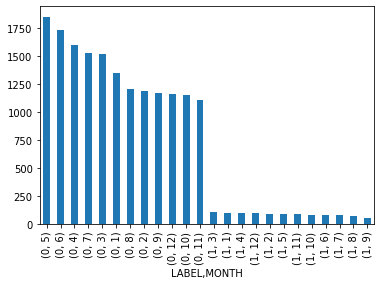

In [ ]:
df.groupby(['LABEL'])['MONTH'].value_counts().plot(kind='bar',stacked=True)

In [ ]:
plot_df=df.groupby(['MONTH'])['LABEL'].value_counts().reset_index(name='Count')

[Text(0.5, 1.0, 'Casualty vs No Casualty Count by MONTH')]

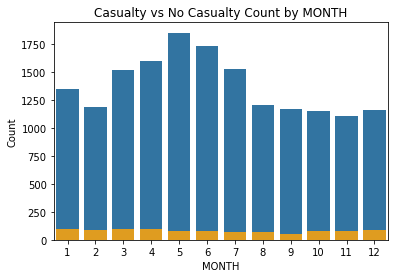

In [ ]:
s1=sns.barplot(x='MONTH', y='Count', data=plot_df[plot_df['LABEL']==0], color='C0')
s2=sns.barplot(x='MONTH', y='Count', data=plot_df[plot_df['LABEL']==1], color='orange')
s1.set(title='Casualty vs No Casualty Count by MONTH')
#s1.set(ylabel='Value Counts')

In [ ]:
for c in Time_var:
  plt.figure(figsize=(20,7))
  cat_count=df[c].value_counts(normalize=True, dropna=False)
  fig=sns.barplot(100*cat_count.values[0:11], cat_count.index[0:11], alpha=0.9)
  plt.title('Frequency Distribution of ' + str(c))
  plt.xlabel('% occurences', fontsize=12)
  #fig.set_yticklabels(fig.get_yticklabels(),rotation=45, horizontalalignment='right')
  plt.show()

In [ ]:
#df['label']=df['Civilian_Casualties'].apply(lambda x: 1 if x>0 else 0)

In [ ]:
#df['label'].value_counts()

0    16543
1    993  
Name: label, dtype: int64

In [ ]:
my_not_needed_cols = ['Station_Area', 'TFS_Alarm_Timeinc_', 'TFS_Arrival_Time',
                      'YEAR','TFS_ARR_DAY','TFS_ALM_DAY','TFS_ARR_HOUR','TFS_ALM_HOUR']
# additional numerical columns that are not needed
add_num_cols = ['Incident_Station_Area', 'Incident_Ward','ADDRESS_POINT_ID', 'ADDRESS_ID',
       'CENTRELINE_ID', 'ADDRESS_NUMBER', 'OBJECTID', 'fs_Longitude',
       'fs_Latitude', 'Latitude', 'Longitude']
add_cat_cols = ['Intersection', 'Last_TFS_Unit_Clear_Time','TFS_Alarm_Timeinc_', 
        'TFS_Arrival_Time', 'NAME', 'ADDRESS','LINEAR_NAME_FULL', 'PLACE_NAME', 
        'WARD_NAME', 'MUNICIPALITY_NAME', 'geometry','INCIDENT_DATE',
                'Ext_agent_app_or_defer_time','Fire_Under_Control_Time','location']

fire_not_needed_cols = ['_id_x','_id_y','Exposures']
Demographics_not_needed_cols = ['fsa_imputed','location']                        
station_not_needed_cols=['ID', 'ADDRESS_ID_LINK', 'X','Y', 'LATITUDE', 'LONGITUDE','POSTAL_CODE','MAINT_STAGE','GENERAL_USE','CLASS_FAMILY_DESC', 'INCIDENT_PERIOD_CAT']
weather_not_needed_cols=['date', 'Incident_Numberdemo','TFS_Alarm_Timedemo']
drop_columns = my_not_needed_cols + add_num_cols + add_cat_cols + Demographics_not_needed_cols + fire_not_needed_cols + station_not_needed_cols + weather_not_needed_cols
df.drop(columns=drop_columns, axis=1,inplace=True)

In [ ]:
find_diff_type_var(df)

(Index(['Area_of_Origin', 'Building_Status', 'Business_Impact',
        'Extent_Of_Fire', 'Final_Incident_Type',
        'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation',
        'Fire_Alarm_System_Presence', 'Ignition_Source', 'Incident_Numberinc_',
        'Initial_CAD_Event_Type', 'Level_Of_Origin', 'Material_First_Ignited',
        'Method_Of_Fire_Control', 'Possible_Cause', 'Property_Use',
        'Smoke_Alarm_at_Fire_Origin',
        'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
        'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
        'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
        'Smoke_Spread', 'Sprinkler_System_Operation',
        'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival', 'FSA'],
       dtype='object'),
 Index(['Civilian_Casualties', 'Count_of_Persons_Rescued',
        'Estimated_Dollar_Loss', 'Estimated_Number_Of_Persons_Displaced',
        'Number_of_responding_apparatus', 'Number_of_responding_personnel',
      

## Imputation

In [ ]:
# Impute null categorical variables
# only one missing for 'Property_Use'
df.at[df[df['Property_Use'].isnull()].index,'Property_Use']='Other'
# Level of Origin
#impute with '999'
df.at[df[df['Level_Of_Origin'].isnull()].index,'Level_Of_Origin']='999'

In [ ]:
# Impute with the most frequent category
cols_to_impute=['Ignition_Source','Material_First_Ignited','Possible_Cause']
for col in cols_to_impute:
  df_test=impute_frequent(col)
print(df[cols_to_impute].isnull().sum())

Ignition_Source           0
Material_First_Ignited    0
Possible_Cause            0
dtype: int64


##Demographics Variables

In [ ]:
#Demographics variables
#Pearson Correlation Coefficient 
#corr = df.select_dtypes(include = ['float64', 'int64']).corr()
corr=df[['density','poor_building_condition','condo_dwelling','Average_Age','Median_Age','male','label']].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=1, square=True, annot=True)

KeyError: ignored

In [ ]:
# calculate correlation between FSA and 
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (math.sqrt(stat/(obs*mini)))

cramers_V(df['label'],df['FSA'])

KeyError: ignored

## Categorical variables in original dataset

In [ ]:
cat_var = df.loc[:,df.dtypes == np.object].columns
n_cat = [df[x].unique().shape[0] for x in cat_var]
n_missing=[df[x].isnull().sum() for x in cat_var]

In [ ]:
cat_var_summary=pd.DataFrame(data=zip(n_cat,n_missing),index=cat_var, columns=['number of categories','number of missing records']).sort_values(by=['number of categories'], ascending=False)

In [ ]:
high_cat=cat_var_summary[cat_var_summary['number of categories']>=20]
med_cat=cat_var_summary[(cat_var_summary['number of categories']>5) & (cat_var_summary['number of categories']<20)]
low_cat=cat_var_summary[cat_var_summary['number of categories']<=5]

In [ ]:
# Categorical variables with high cardinality
#FSA: impute with numerical % incident with casualty

In [ ]:
cat_var_id=['Incident_Numberinc_','FSA']
high_cat=[x for x in high_cat.index if x not in cat_var_id]

In [ ]:
cat_var_summary

,number of categories,number of missing records
Incident_Numberinc_,17536,0
Property_Use,284,0
Initial_CAD_Event_Type,115,0
FSA,96,0
Ignition_Source,84,0
Area_of_Origin,74,1913
Level_Of_Origin,59,0
Material_First_Ignited,54,0
Possible_Cause,24,0
Extent_Of_Fire,13,6322


In [ ]:
for c in high_cat:
  exploration_cat(c)

---------------------------------------
variable name: Property_Use 

number of categories:  284 

323 - Multi-Unit Dwelling - Over 12 Units                                        0.220632
301 - Detached Dwelling                                                          0.141766
901 - Automobile                                                                 0.082345
896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)    0.053718
302 - Semi-Detached Dwelling                                                     0.044138
848 - Trash/Rubbish/Garbage Container or Dumpster                                0.042313
303 - Attached Dwelling (eg. rowhouse, townhouse, etc.)                          0.034500
861 - Open Land (eg. light ground cover, bush, grass, etc.)                      0.027030
902 - Small Truck (eg. pick-up, van, etc.)                                       0.020814
321 - Multi-Unit Dwelling - 2 to 6 Units                                         0.016423
3

In [ ]:
df[df['Level_Of_Origin']=='997']

In [ ]:
med_cat=[x for x in med_cat.index if x not in cat_var_id]
for c in med_cat:
  exploration_cat(c)

### High Card: FSA frequency encoding

In [ ]:
#encode FSA with frequency (numerical)
df=freq_encode('FSA')

### High Card: Possible Cause


*   evaluate woe for each category
*   List item



In [ ]:
df_test=woe_encoder('Possible_Cause','LABEL')

In [ ]:
df_test[['Possible_Cause','Possible_Cause_woe']].drop_duplicates().sort_values(by='Possible_Cause_woe')

,Possible_Cause,Possible_Cause_woe
13,"28 - Routine maintenance deficiency, eg creosote, lint, grease buildup",-1.421197
21,51 - Mechanical Failure,-1.358665
1,03 - Suspected Vandalism,-1.299777
106,49 - Improper Storage,-1.257930
947,73 - Natural Cause,-0.995566
6,20 - Design/Construction/Installation/Maintenance Deficiency,-0.823195
0,99 - Undetermined,-0.610312
58,01 - Suspected Arson,-0.546298
7,52 - Electrical Failure,-0.400887
48,45 - Improperly Discarded,-0.331906


In [ ]:
df_test=woe_encoder('Initial_CAD_Event_Type','LABEL')

In [ ]:
df_test[['Initial_CAD_Event_Type','Initial_CAD_Event_Type_woe']].drop_duplicates().sort_values(by='Initial_CAD_Event_Type_woe')

,Initial_CAD_Event_Type,Initial_CAD_Event_Type_woe
1,Fire - Grass/Rubbish,-3.526908
4834,VEFH,-2.105228
4837,FIG,-2.058633
4832,VEF,-1.882695
0,Vehicle Fire,-1.558351
41,Vehicle Fire - Highway,-1.552002
5019,FITP,-1.223144
4920,FIS,-1.168585
4933,FII,-1.159195
181,Fire - Other,-0.973093


In [ ]:
df_test=woe_encoder('Property_Use','LABEL')

In [ ]:
df_test[['Property_Use','Property_Use_woe']].drop_duplicates().sort_values(by='Property_Use_woe')

,Property_Use,Property_Use_woe
30,848 - Trash/Rubbish/Garbage Container or Dumpster,-3.799600
28,144 - Subway Station,-2.324702
9,901 - Automobile,-2.261992
33,846 - Hydro/Telephone Pole,-2.048716
0,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",-1.951077
135,999 - Other Vehicle,-1.753252
52,"861 - Open Land (eg. light ground cover, bush, grass, etc.)",-1.734324
71,132 - School - Elementary,-1.583353
181,365 - Detached Garage,-1.401031
148,"862 - Forest, Standing Timber",-1.393596


### High Card: Level of Origin binning


* 001-003 low_rise_level
* 004-012 mid_rise_level
* 012-100 high_rise_level
* 996 roof
* B - below_grade_level
* rest including NaN - other



In [ ]:
# Binning Level of 
LOO_imputed=[None]*len(LOO)
for i in range(len(LOO)):
  try: 
    #LOO_imputed[i]=int(LOO[i])
    if int(LOO[i])<=3:
      LOO_imputed[i]='low_rise_level'
    elif int(LOO[i])<=12:
      LOO_imputed[i]='mid_rise_level'
    elif int(LOO[i])<=100:
      LOO_imputed[i]='high_rise_level'
    elif int(LOO[i])==996:
      LOO_imputed[i]='roof'
    else:
      LOO_imputed[i]='other'
  except:
    LOO_imputed[i]='below_grade_level'
print(LOO_imputed[0:50])

['other', 'other', 'other', 'other', 'other', 'other', 'low_rise_level', 'mid_rise_level', 'low_rise_level', 'other', 'other', 'low_rise_level', 'other', 'low_rise_level', 'other', 'other', 'low_rise_level', 'high_rise_level', 'low_rise_level', 'other', 'other', 'other', 'mid_rise_level', 'low_rise_level', 'other', 'other', 'low_rise_level', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'low_rise_level', 'other', 'other', 'other', 'other', 'other', 'other', 'low_rise_level', 'other', 'low_rise_level', 'mid_rise_level', 'other', 'other', 'mid_rise_level', 'other']


In [ ]:
df['LOO_imputed']=LOO_imputed

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


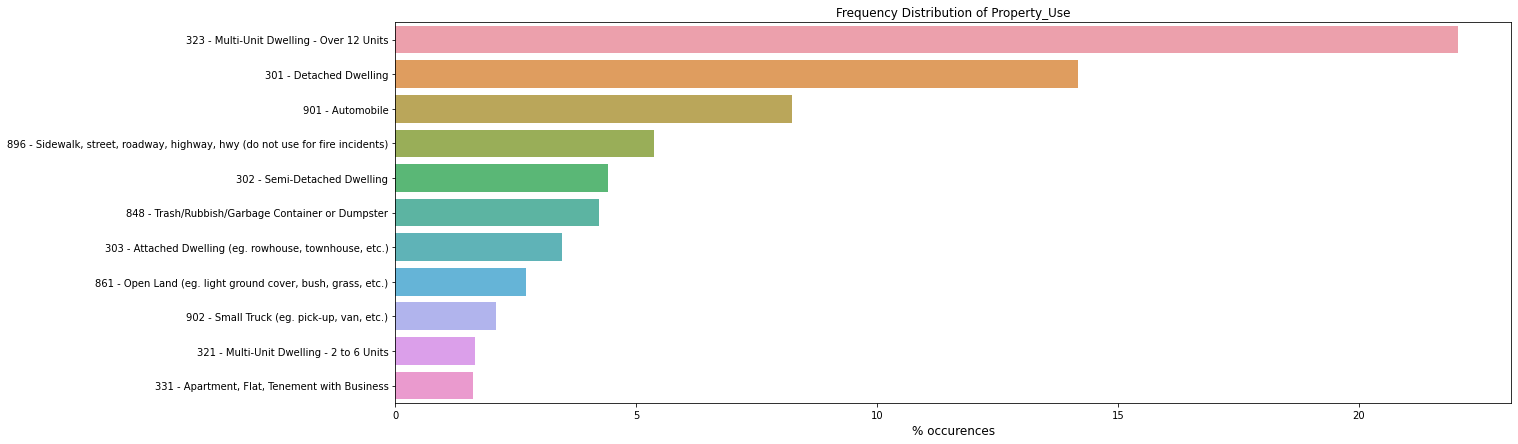

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


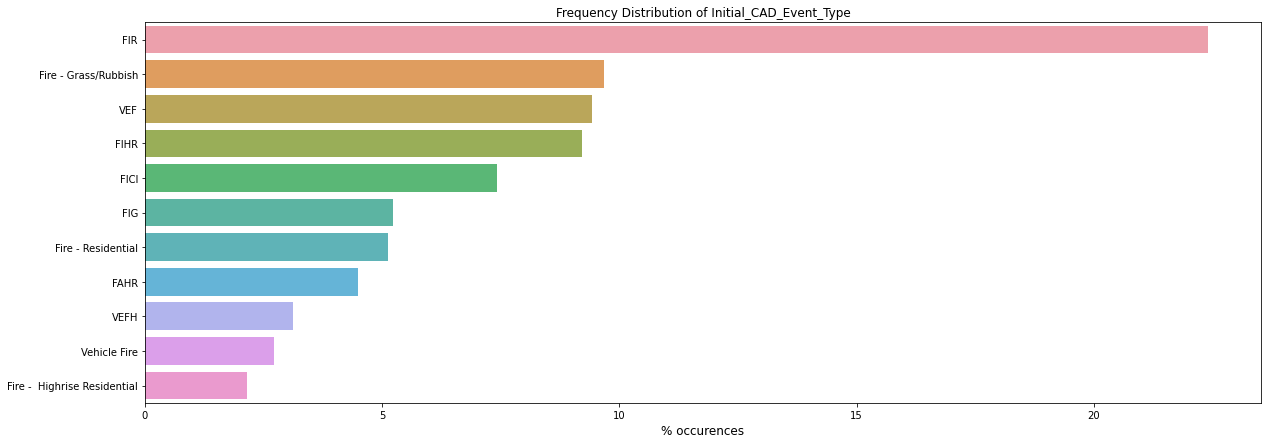

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


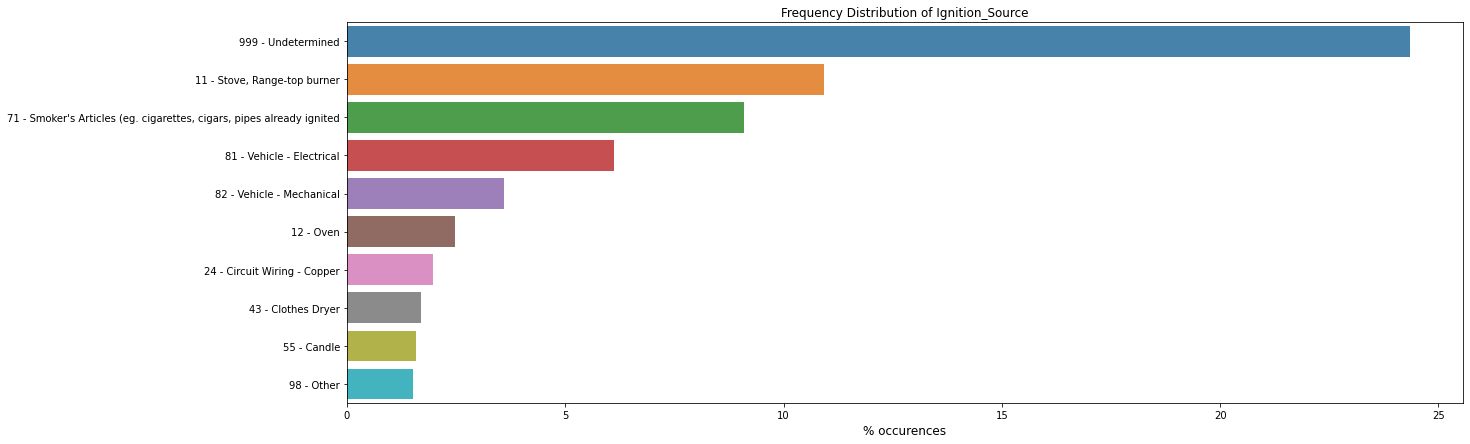

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


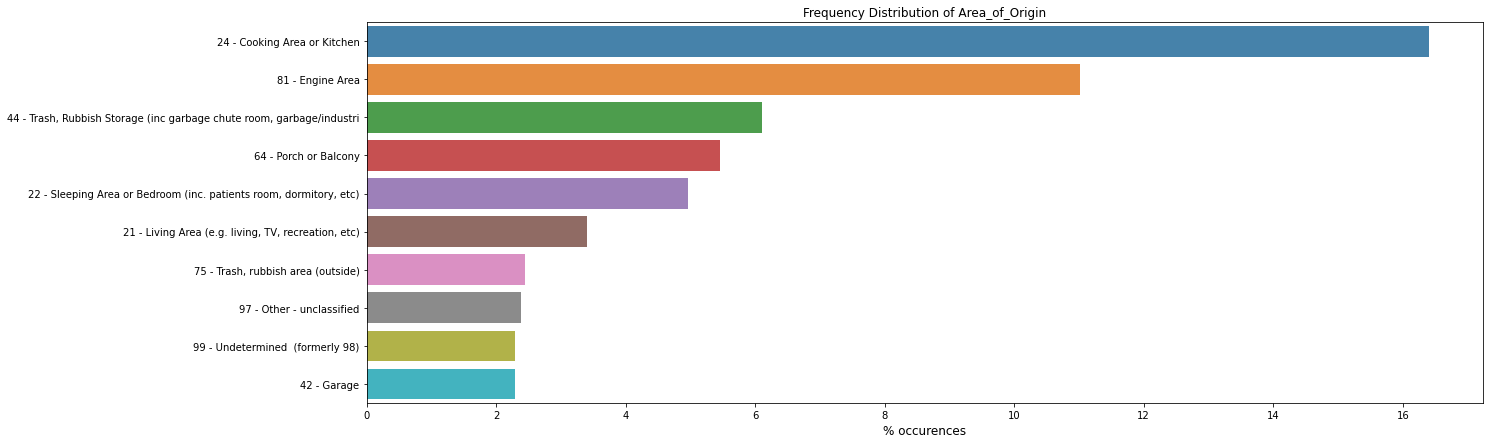

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


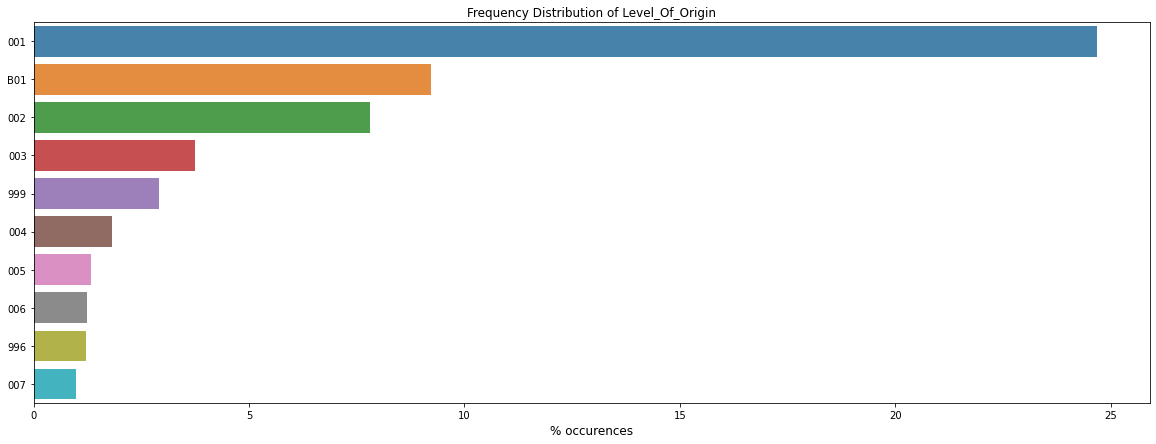

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


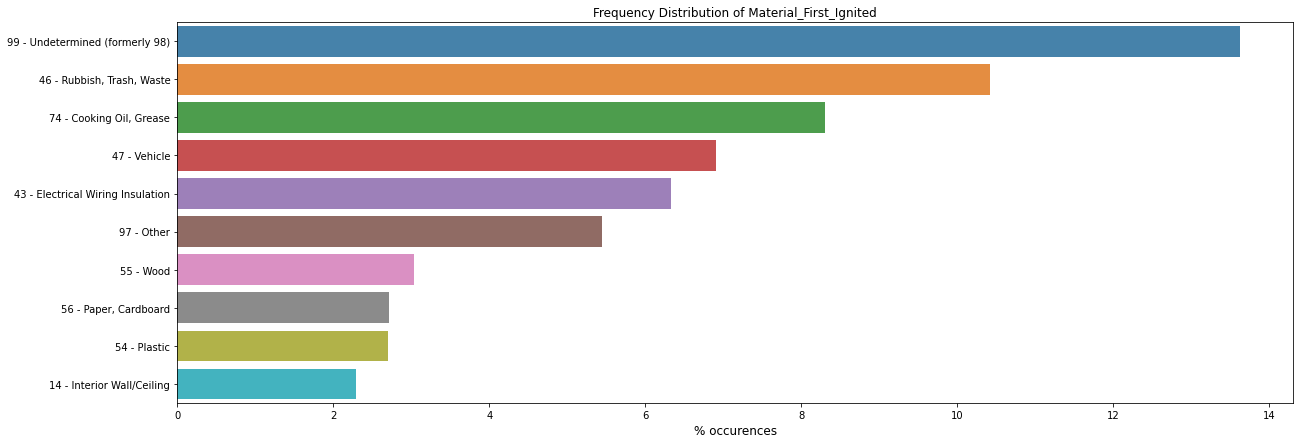

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


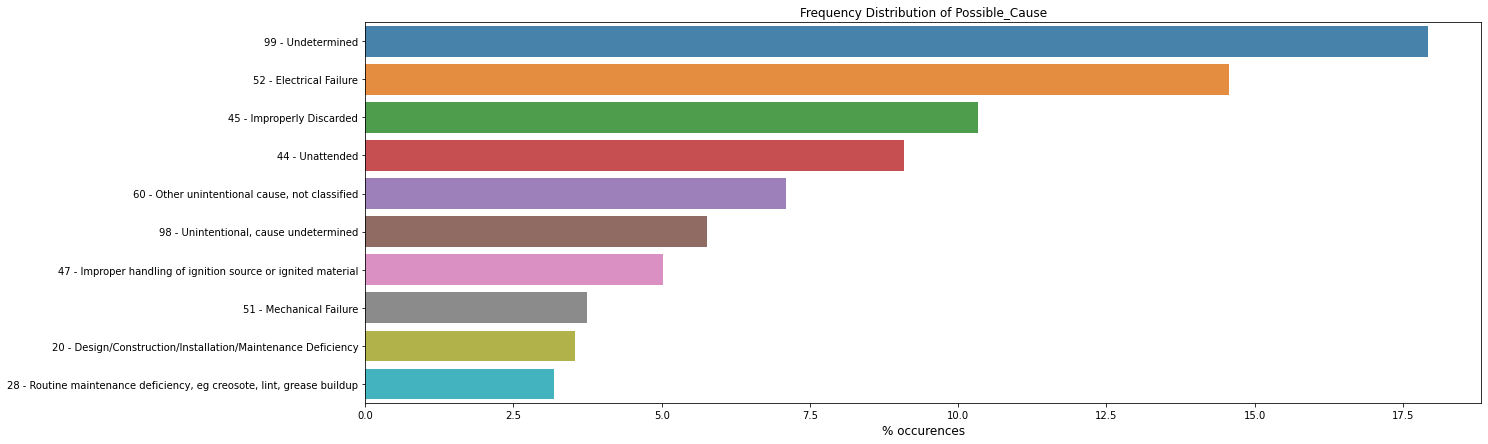

In [ ]:
for c in high_cat:
  plot_cat(c)

##Property Use: https://link.springer.com/article/10.1007/s10994-018-5724-2


In [ ]:
import re,os
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,classification_report,confusion_matrix,precision_recall_curve,auc,roc_auc_score,f1_score
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

!pip install unidecode
import unidecode

!pip install contractions
import contractions

!pip install swifter
import swifter #https://github.com/jmcarpenter2/swifter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 235 kB 5.1 MB/s 
     |████████████████████████████████| 284 kB 5.3 MB/s 
     |████████████████████████████████| 321 kB 35.9 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85447 sha256=26b52f04cedae26000887da5d6569ba80f06d4afb1b2db92dfd30b4f1d7f5a03
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
     |████████████████████████████████| 296 kB 5.2 MB/s 
     |████████████████████████████████| 132 kB 50.3 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4

In [ ]:
df[df['Property_Use'].isnull()]

,_id_x,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Number,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Latitude,Level_Of_Origin,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Timeinc_,TFS_Arrival_Time,TFS_Firefighter_Casualties,_id_y,ID,NAME,ADDRESS,ADDRESS_POINT_ID,ADDRESS_ID,CENTRELINE_ID,MAINT_STAGE,ADDRESS_NUMBER,LINEAR_NAME_FULL,POSTAL_CODE,GENERAL_USE,CLASS_FAMILY_DESC,ADDRESS_ID_LINK,PLACE_NAME,X,Y,LATITUDE,LONGITUDE,WARD_NAME,MUNICIPALITY_NAME,OBJECTID,geometry,fs_Longitude,fs_Latitude,Station_Area,LABEL,DISTANCE_INCIDENT_FIRESTATION,INCIDENT_DATE,DOW,IS_WEEKEND,YEAR,MONTH,MINUTES_TO_ARRIVE,TFS_ARR_DAY,TFS_ALM_DAY,TFS_ARR_HOUR,TFS_ALM_HOUR,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,INCIDENT_PERIOD_CAT,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,date,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,TFS_Alarm_Timedemo,location,FSA,fsa_imputed,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male,label
17276,1964205,79 - Other Outside Area,NaN,NaN,0,0,NaN,NaN,NaN,2013-04-17 22:37:00,NaN,01 - Fire,NaN,NaN,NaN,NaN,999 - Undetermined,F13029095,442,11.0,FAHR,Weston Rd / Oak St,2013-04-17 22:46:40,43.70779,NaN,-79.53363,"31 - Mattress, Pillow",1 - Extinguished by fire department,5,18,99 - Undetermined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3 - Fire with smoke showing only - including vehicle, outdoor fires",2013-04-17 22:29:19,2013-04-17 22:35:26,0,71,81,FIRE STATION 442,2015 LAWRENCE AVE W,9796836,34953,9796835,REGULAR,2015,Lawrence Ave W,NaN,Fire/Ambulance Stations,"Land, Structure, Structure Entrance",NaN,"Fire Station 442, Ambulance Station 10",NaN,NaN,NaN,NaN,York South-Weston (5),York,3234576,"{u'type': u'Point', u'coordinates': (-79.5123844109, 43.7005987012)}",-79.512384,43.700599,442,0,13701.458324,2013-04-17 00:00:00,2,0,2013,4,6.117,17,17,22,22,11.233,6,Night,0,0,0,0,2013-04-17,2.32,0.06,0.0,7.515,64.51,17.19,2013-04-17 22:29:19,M9N 3V9,M9N,0,4928.6,0.09292,0.117502,39.3,39.0,0.472981,0


In [ ]:
df_p=df[['Property_Use','label']]

In [ ]:
df_p.shape

(17536, 3)

In [ ]:
[np.where(df_p['Property_Use'].isnull())[0][0]]

[17276]

In [ ]:
df_p=df_p.drop(labels=[np.where(df_p['Property_Use'].isnull())[0][0]],axis=0)

In [ ]:
df_p['Property_Use'].isnull().sum()

0

In [ ]:
# clean text
def clean_text(text):
  # replace all non-printable characters (such as "\n") with space, and replace multiple spaces with single space
  df_p['ss_text']=text.apply(lambda x: ' '.join(c for c in x.split()))
  #expand contraction
  df_p['contract_text']=df_p['ss_text'].apply(lambda x: ' '.join([contractions.fix(w) for w in x.split()]))
  #lower case
  df_p['lower_text']=df_p['contract_text'].apply(lambda x: ' '.join([w.lower() for w in x.split()]))
  #lemmatization
  lmtzr=WordNetLemmatizer()
  df_p['lemm_text']=df_p['lower_text'].apply(lambda x: ' '.join([lmtzr.lemmatize(w) for w in x.split()]))

  #remove punctuation
  df_p['punct_text']=df_p['lemm_text'].str.replace('[^\w\s]',' ')
  #remove english stopwords
  STOPWORDS=set(stopwords.words('english'))
  df_p['stop_text']=df_p['punct_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS]))
  #remove all numbers
  df_p["text_cleaned"]=df_p['stop_text'].apply(lambda x: ' '.join([w for w in x.split() if not w.isdigit()]))
  #return
  return df_p["text_cleaned"]

In [ ]:
clean_text(df_p['Property_Use'])

0        sidewalk street roadway highway hwy use fire incidents         
1        sidewalk street roadway highway hwy use fire incidents         
2        outdoor general auto parking                                   
3        department store                                               
4        lawn around structure                                          
5        vehicle vehicle part                                           
6        detached dwelling                                              
7        multi unit dwelling unit                                       
8        court facility                                                 
9        automobile                                                     
10       gymnasium                                                      
11       attached dwelling eg rowhouse townhouse etc                    
12       multi unit dwelling unit                                       
13       apartment flat tenement business          

In [ ]:
df_p[df_p['text_cleaned']==""]

,Property_Use,label,ss_text,contract_text,lower_text,lemm_text,punct_text,stop_text,text_cleaned


In [ ]:
word_list=' '.join(df_p['text_cleaned'])
word_listing=str(word_list).split()

In [ ]:
from collections import Counter
c=Counter(word_listing)
sorted_list=sorted(c.items(),key=lambda i:i[1],reverse=True)
top20=sorted_list[0:20]
top20

[('unit', 8618),
 ('dwelling', 8279),
 ('multi', 4373),
 ('detached', 3484),
 ('etc', 1610),
 ('eg', 1579),
 ('automobile', 1444),
 ('fire', 946),
 ('sidewalk', 942),
 ('street', 942),
 ('roadway', 942),
 ('highway', 942),
 ('hwy', 942),
 ('use', 942),
 ('incidents', 942),
 ('semi', 842),
 ('trash', 742),
 ('rubbish', 742),
 ('garbage', 742),
 ('container', 742)]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_p["text_cleaned"], df_p["label"], test_size=0.2, random_state=10086, stratify=df_p["label"])
print(X_train.shape)
print(X_test.shape)

(14028,)
(3507,)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [ ]:
pipeline_bow_bg = Pipeline([('vectorizer', CountVectorizer(max_features=1000,ngram_range=(2,3))), ('dtf', DenseTransformer()),('scaler', StandardScaler()), ('LR', LogisticRegression(random_state=2020))])
pipeline_bow_bg.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=1000, ngram_range=(2, 3))),
                ('dtf', <__main__.DenseTransformer object at 0x7f318df08190>),
                ('scaler', StandardScaler()),
                ('LR', LogisticRegression(random_state=2020))])

In [ ]:
#accuracy
pipeline_bow_bg.score(X_test,y_test)

0.9432563444539492

In [ ]:
## f1 score
f1_score(y_test,pipeline_bow_bg.predict(X_test))

0.0

In [ ]:
## roc auc score
roc_auc_score(y_test, pipeline_bow_bg.predict_proba(X_test)[:,1])

0.710552460002552

In [ ]:
#coefficients (coef_) of your logisitic regression model, which features are most positively/negatively correlated with toxic comments?
feature_names_bg=pipeline_bow_bg.named_steps['vectorizer'].get_feature_names()

In [ ]:
len(feature_names_bg)

1000

In [ ]:
feature_coeff_bg=pipeline_bow_bg.named_steps['LR'].coef_[0]
bg_feature_df=pd.DataFrame()
bg_feature_df['feature']=feature_names_bg
bg_feature_df['coeff']=feature_coeff_bg
bg_feature_df['abs']=np.abs(feature_coeff_bg)
bg_feature_df.sort_values(by='abs',ascending=False, inplace=True)

In [ ]:
bg_feature_df.head(20)

,feature,coeff,abs
184,detached dwelling,0.887952,0.887952
870,subway station,-0.342435,0.342435
739,school elementary,-0.230320,0.230320
572,multi unit dwelling,0.223743,0.223743
950,unit dwelling,0.223743,0.223743
951,unit dwelling unit,0.223743,0.223743
571,multi unit,0.223743,0.223743
215,dwelling unit,0.223743,0.223743
185,detached dwelling business,-0.195300,0.195300
694,recycling facility,-0.195043,0.195043


In [ ]:
df_p[df_p['Property_Use'].str.contains('Subway')]

,Property_Use,label,ss_text,contract_text,lower_text,lemm_text,punct_text,stop_text,text_cleaned
28,144 - Subway Station,0,144 - Subway Station,144 - Subway Station,144 - subway station,144 - subway station,144 subway station,144 subway station,subway station
29,144 - Subway Station,0,144 - Subway Station,144 - Subway Station,144 - subway station,144 - subway station,144 subway station,144 subway station,subway station
125,144 - Subway Station,0,144 - Subway Station,144 - Subway Station,144 - subway station,144 - subway station,144 subway station,144 subway station,subway station
327,144 - Subway Station,0,144 - Subway Station,144 - Subway Station,144 - subway station,144 - subway station,144 subway station,144 subway station,subway station
443,144 - Subway Station,0,144 - Subway Station,144 - Subway Station,144 - subway station,144 - subway station,144 subway station,144 subway station,subway station
511,144 - Subway Station,0,144 - Subway Station,144 - Subway Station,144 - subway station,144 - subway station,144 subway station,144 subway station,subway station
541,144 - Subway Station,0,144 - Subway Station,144 - Subway Station,144 - subway station,144 - subway station,144 subway station,144 subway station,subway station
547,144 - Subway Station,0,144 - Subway Station,144 - Subway Station,144 - subway station,144 - subway station,144 subway station,144 subway station,subway station
715,144 - Subway Station,0,144 - Subway Station,144 - Subway Station,144 - subway station,144 - subway station,144 subway station,144 subway station,subway station
828,144 - Subway Station,0,144 - Subway Station,144 - Subway Station,144 - subway station,144 - subway station,144 subway station,144 subway station,subway station


##Smoke Alarm

In [ ]:
missing_smoke=df[df['Smoke_Alarm_at_Fire_Origin'].isnull()]

In [ ]:
missing_smoke.shape

(6322, 56)

In [ ]:
other_Variables=['Extent_Of_Fire','Business_Impact','Fire_Alarm_System_Presence']

In [ ]:
missing_smoke.select_dtypes(include='object').isnull().sum()

Area_of_Origin                                                   1913
Building_Status                                                  6320
Business_Impact                                                  6322
Extent_Of_Fire                                                   6322
Final_Incident_Type                                              0   
Fire_Alarm_System_Impact_on_Evacuation                           6322
Fire_Alarm_System_Operation                                      6322
Fire_Alarm_System_Presence                                       6322
Ignition_Source                                                  0   
Incident_Numberinc_                                              0   
Initial_CAD_Event_Type                                           0   
Level_Of_Origin                                                  6322
Material_First_Ignited                                           0   
Method_Of_Fire_Control                                           1914
Possible_Cause      

In [ ]:
smoke_variables=['Smoke_Alarm_at_Fire_Origin','Smoke_Alarm_at_Fire_Origin_Alarm_Failure','Smoke_Alarm_at_Fire_Origin_Alarm_Type','Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation','Smoke_Spread','Sprinkler_System_Operation','Sprinkler_System_Presence']

In [ ]:
for c in smoke_variables:
  missing=missing_smoke[c].isnull().sum()
  print('variable name:', c, ': ', missing)

variable name: Smoke_Alarm_at_Fire_Origin :  6322
variable name: Smoke_Alarm_at_Fire_Origin_Alarm_Failure :  6322
variable name: Smoke_Alarm_at_Fire_Origin_Alarm_Type :  6322
variable name: Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation :  6322
variable name: Smoke_Spread :  6322
variable name: Sprinkler_System_Operation :  6322
variable name: Sprinkler_System_Presence :  6322


In [ ]:
missing_smoke['Property_Use'].value_counts(normalize=True,dropna=False)#.cumsum()

901 - Automobile                                                                 0.228251
896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)    0.149003
848 - Trash/Rubbish/Garbage Container or Dumpster                                0.117210
861 - Open Land (eg. light ground cover, bush, grass, etc.)                      0.074976
902 - Small Truck (eg. pick-up, van, etc.)                                       0.057735
898 - Other property non structure not classified                                0.030528
891 - Outdoor general auto parking                                               0.028472
301 - Detached Dwelling                                                          0.026574
903 - Large Truck (Excluding Truck Trailer)                                      0.026099
323 - Multi-Unit Dwelling - Over 12 Units                                        0.023727
837 - Vehicles or Vehicle Parts                                                  0.022303
846 - Hydr

# Functions

In [ ]:
# extract categorical vs. numerical columns
def find_diff_type_var(df):
    cat_var = df.loc[:,df.dtypes == np.object].columns
    num_var = df.loc[:,df.dtypes != np.object].columns
    return(cat_var, num_var)

In [ ]:
# explore different variables
def exploration_cat(c):

  print('---------------------------------------')

  print('variable name:', c, '\n')
  print('number of categories: ' ,df[c].unique().shape[0], '\n')
  print(df[c].value_counts(normalize=True, dropna=False))

  print('---------------------------------------')

In [ ]:
# plot categorical variables
def plot_cat(c):
  plt.figure(figsize=(20,7))
  cat_count=df[c].value_counts(normalize=True, dropna=False)
  fig=sns.barplot(100*cat_count.values[0:11], cat_count.index[0:11], alpha=0.9)
  plt.title('Frequency Distribution of ' + str(c))
  plt.xlabel('% occurences', fontsize=12)
  #fig.set_yticklabels(fig.get_yticklabels(),rotation=45, horizontalalignment='right')
  plt.show()


In [ ]:
# frequency encoding
def freq_encode(c):
  freq_count=df[c].value_counts(normalize=True).to_dict()
  c_imputed=str(c)+'_imputed'
  df[c_imputed]=df[c].map(freq_count)
  return df

In [ ]:
# Impute with the most frequent category
def impute_frequent (c):
  top_cat=df[c].value_counts().nlargest(1).index[0]
  index_to_impute=df[df[c].isnull()].index
  df.at[index_to_impute,c]=top_cat
  return df

In [ ]:
# use WOE for categorical variables
def woe_encoder(c,target):
  from category_encoders import WOEEncoder
  x = WOEEncoder()
  x.fit(df[c],df[target])
  df[str(c)+'_woe']=x.transform(df[c],df[target])
  return df

# Plot FSA data on map [link](https://stackoverflow.com/questions/58043978/display-data-on-real-map-based-on-postal-code) done on local machine


In [ ]:
#load sample data
df=pd.read_csv('fire1_FSA.csv')

# New Section

In [ ]:
df['casualty_flag']=np.where(df['Civilian_Casualties']!=0, 1, 0)

In [ ]:
df_casualty=df['casualty_flag'].groupby(df['FSA']).sum()
df_incident=df['FSA'].value_counts()

In [ ]:
df_casualty=df_casualty.reset_index()
df_incident=df_incident.reset_index()

In [ ]:
df_incident=df_incident.rename(columns={'index':'FSA', 'FSA':'count'})
df_incident.head()

,FSA,count
0,M5A,213
1,M5V,163
2,M3N,153
3,M4Y,153
4,M9W,153


In [ ]:
df_casualty.head()

,FSA,casualty_flag
0,K4A,0
1,L1V,0
2,L3R,0
3,L3T,1
4,L4J,0


In [ ]:
df_casualty_incident=df_incident.merge(df_casualty, how='left', on='FSA')

In [ ]:
df_casualty_incident.head()
df_casualty_incident['likelihood']=df_casualty_incident['casualty_flag']/df_casualty_incident['count']

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 4.7 MB/s 
     |████████████████████████████████| 6.3 MB 43.4 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 


In [ ]:
pip install pandas-bokeh

In [ ]:
import geopandas
import pandas as pd
import pandas_bokeh
import matplotlib.pyplot as plt
pandas_bokeh.output_notebook()

canada = geopandas.read_file("./gfsa000b11a_e.shp")
ontario = canada[canada['PRUID'] == '35']

# Sample data to plot
#df=pd.DataFrame({'PCODE': ['P0V','P0L','P0T','P0Y', 'P0G', 'P2N'], 'A':[6,3,5,2,2,4] })

# Join ontario dataset with sample data
new_df=ontario.join(df_casualty_incident.set_index('FSA'), on='CFSAUID')


new_df.plot_bokeh(simplify_shapes=20000,
                  category="casualty_flag", 
                  colormap="Spectral", 
                  hovertool_columns=["CFSAUID","A"])

DriverError: ignored